# Сборный проект 5 - Поиск по изображениям

## Описание проекта

### Цель и вводные данные
Разработка экспериментальной модели поиска референсных фотографий для фотохостинга для профессиональных фотографов «Со Смыслом» (“With Sense”). Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой.

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

Необходимо презентовать PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. 

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 

На основе лучшей модели можно собрать предварительную версию продукта.


### Юридические ограничения
В некоторых странах действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

При попытке посмотреть такиен изображения, вместо картинок показывается дисклеймер:
> This image is unavailable in your country in compliance with local laws.

Необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер. 


### Описание данных

Данные доступны по ссылке [https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Подготовка

In [1]:
#!pip install torchvision

### Импорт библиотек

In [2]:
import os
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import scipy.stats as st
import torch
import transformers

from catboost import CatBoostClassifier, Pool
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from tqdm import tqdm_pandas
from sklearn.metrics import precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GroupShuffleSplit
from transformers import AutoTokenizer, AutoModel

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

### Настройки по умолчанию

In [3]:
# Применим настройку формата чисел с разделителем
pd.options.display.float_format = '{:_.4f}'.format
# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)
mp.set_start_method('spawn', force=True)

### Константы

In [4]:
RANDOM_STATE = 1234
BATCH_SIZE = 100
TRAIN_IMAGE_FOLDER = 'to_upload/train_images'
TEST_IMAGE_FOLDER = 'to_upload/test_images'

### Загрузка данных

In [5]:
# Создаем переменные с датафреймами датафрей проверяем три источника данных
try:
    if os.path.exists('/datasets/'):
        path = '/datasets/'
    elif os.path.exists('datasets/'):
        path = 'datasets/'
    else:
        path = './'
    print('Каталог с данными:', path)    
except FileNotFoundError:
    print("Ошибка: каталог не найден!")

Каталог с данными: datasets/


In [6]:
crowd_ann_cols = (
    'image',
    'query_id',
    'confirmation_share',
    'confirms',
    'disproves'
)

expert_ann_cols = (
    'image',
    'query_id',
    'expert_1',
    'expert_2',
    'expert_3'
)

In [7]:
train_data = pd.read_csv(
    path + 'to_upload/train_dataset.csv')
crowd_annotations = pd.read_csv(
    path + 'to_upload/CrowdAnnotations.tsv',  sep='\t', header=None, names=crowd_ann_cols)
expert_annotations = pd.read_csv(
    path + 'to_upload/ExpertAnnotations.tsv',  sep='\t', header=None, names=expert_ann_cols)
test_images = pd.read_csv(
    path + 'to_upload/test_images.csv')
test_queries = pd.read_csv(
    path + 'to_upload/test_queries.csv', sep='|', index_col=[0])

### Обзор данных 

In [8]:
# функция вывода первых 5 строк датафрейма и информации о нем.
def head_info(df, rows=5):
    print(f'Первые {rows} строк и информация по датафрейму: \n')
    display(df.head(rows))
    df.info()
    print()

In [9]:
head_info(train_data)

Первые 5 строк и информация по датафрейму: 



image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                                                 query_text  
0  A young child is wearing blue goggles and sitting in a float in a pool .  
1  A young child is wearing blue goggles and sitting in a float in a pool .  
2  A young child is wearing blue goggles and sitting in a float in a pool .  
3  A young child is wearing blue goggles and sitting in a float in a pool .  
4  A young child is wearing blue goggles and sitting in a float in a pool .

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB



In [10]:
head_info(crowd_annotations)

Первые 5 строк и информация по датафрейму: 



image                     query_id  confirmation_share  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0000   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0000   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0000   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0000   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0000   

   confirms  disproves  
0         3          0  
1         0          3  
2         0          3  
3         0          3  
4         0          3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               47830 non-null  object 
 1   query_id            47830 non-null  object 
 2   confirmation_share  47830 non-null  float64
 3   confirms            47830 non-null  int64  
 4   disproves           47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB



In [11]:
head_info(expert_annotations)

Первые 5 строк и информация по датафрейму: 



image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB



In [12]:
head_info(test_images)

Первые 5 строк и информация по датафрейму: 



image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes



In [13]:
head_info(test_queries)

Первые 5 строк и информация по датафрейму: 



query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                                                                       query_text  \
0  Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .   
1                                               Two boys are squirting water guns at each other .   
2                                                         Two boys spraying each other with water   
3                                         Two children wearing jeans squirt water at each other .   
4                                              Two young boys are squirting water at each other .   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB



Данные соответствуют описанию, но используются разные разделители и в данных с анотациями отсутствуют заголовки. 

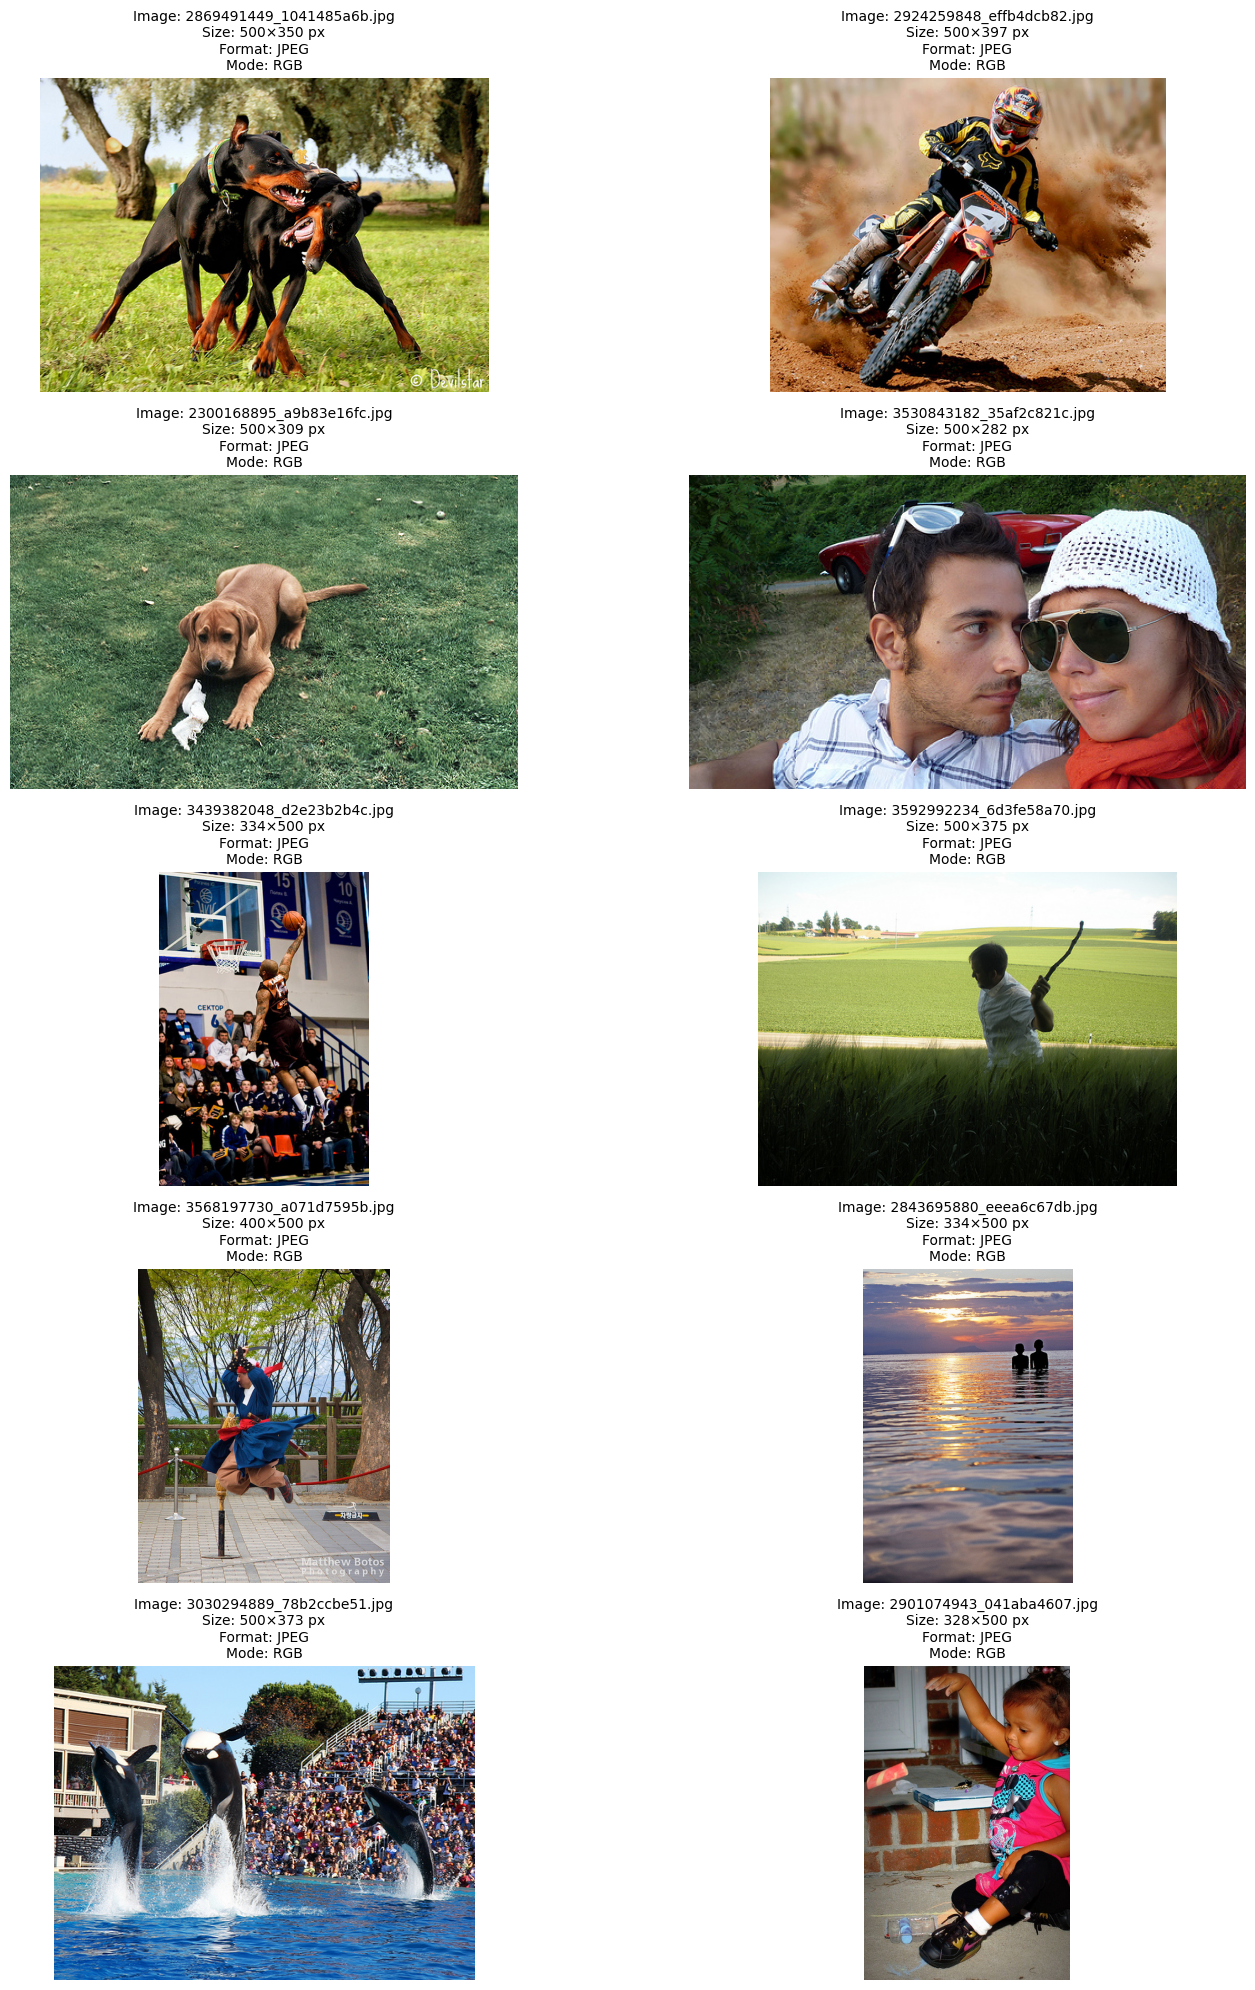

In [14]:
# Путь к папке с изображениями
image_folder = path + TRAIN_IMAGE_FOLDER


# Получаем список файлов изображений (фильтруем по расширениям)
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
image_files = [
    f for f in os.listdir(image_folder)
    if f.lower().endswith(image_extensions)
]

# Берём первые 10 файлов
selected_images = image_files[:10]

# Создаём фигуру для визуализации (2 столбеца, 5 строк)
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()  # упрощаем работу с осями

for i, image_name in enumerate(selected_images):
    # Полный путь к изображению
    image_path = os.path.join(image_folder, image_name)

    # Загружаем изображение
    img = Image.open(image_path)

    # Получаем информацию об изображении
    width, height = img.size
    format = img.format
    mode = img.mode  # RGB, RGBA, L (градации серого) и т. д.

    # Отображаем изображение
    axes[i].imshow(img)
    axes[i].set_title(
        f'Image: {image_name}\n'
        f'Size: {width}×{height} px\n'
        f'Format: {format}\n'
        f'Mode: {mode}',
        fontsize=10
    )
    axes[i].axis('off')  # убираем оси

plt.tight_layout()
plt.show()


Изображения имеют различный размер.

## Исследовательский анализ данных

Проверим данные на дубликаты

In [15]:
train_data.duplicated().sum()

0

In [16]:
crowd_annotations.duplicated().sum()

0

In [17]:
expert_annotations.duplicated().sum()

0

Посмотрим на распределения данных

In [18]:
def plot_hist(column, bins=20, rot=0, name=''):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
    column.plot(kind='hist', bins=bins)
    axes.set_title('Гистограмма распределения')
    axes.set_xlabel(f'Значение {column.name} {name}') 
    axes.set_ylabel('Частота')
    fig.suptitle(f'Анализ распределения значений {column.name}'
                 f' {name}', fontweight='bold')
    plt.show()
    print("\nОписательная статистика:")
    print(column.describe())
    return


def plot_bar(column, rot=0, name=''):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
    counts = column.value_counts().sort_index()
    counts.plot(kind='bar', ax=axes, rot=rot)
    axes.set_title('Распределение в штуках')
    axes.set_xlabel(f'Значение {column.name} {name}') 
    axes.set_ylabel('количество')
    fig.suptitle(f'Распределения значений {column.name}'
                 f' {name}', fontweight='bold')
    plt.show()
    return

Датафрейм crowd_annotations

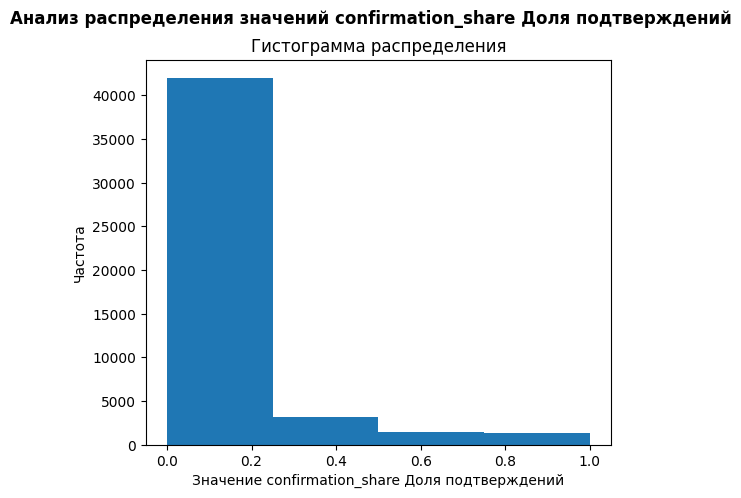


Описательная статистика:
count   47_830.0000
mean         0.0688
std          0.2075
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          1.0000
Name: confirmation_share, dtype: float64


In [19]:
plot_hist(crowd_annotations['confirmation_share'], bins=4, name='Доля подтверждений')

Стедняя доля подтверждений лишь 7%

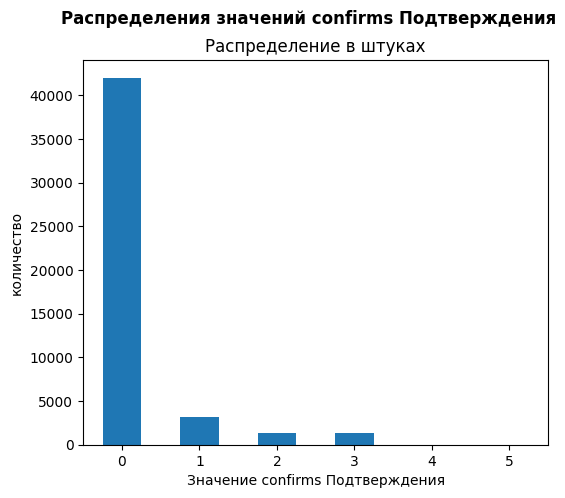

In [20]:
plot_bar(crowd_annotations['confirms'], name='Подтверждения')

В подтверждениях больше всего 0 т.е. ни один человек не подтвердил

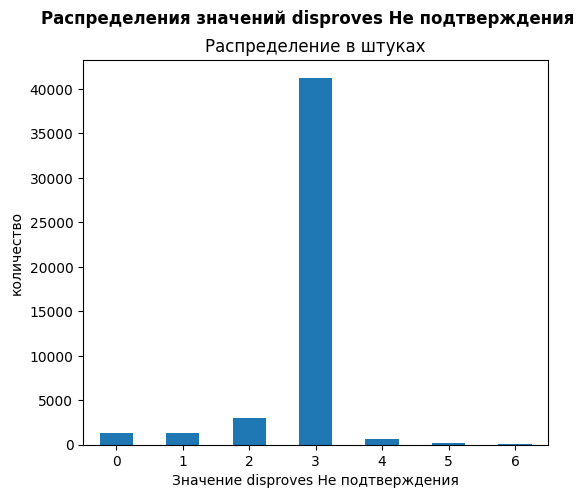

In [21]:
plot_bar(crowd_annotations['disproves'], name='Не подтверждения')

Датафрейм expert_annotations

Не подтверждения обычьно выдают три человека

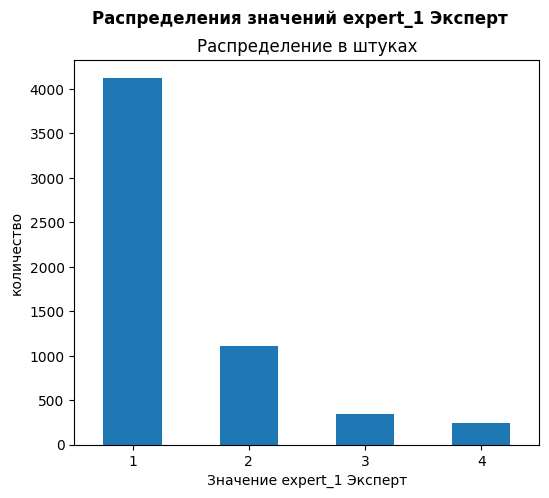

In [22]:
plot_bar(expert_annotations['expert_1'], name='Эксперт')

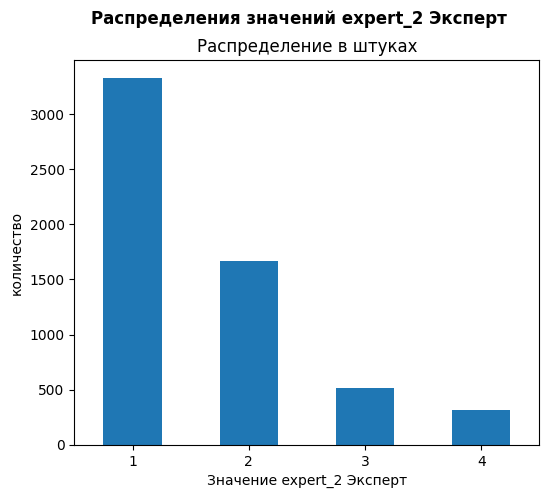

In [23]:
plot_bar(expert_annotations['expert_2'], name='Эксперт')

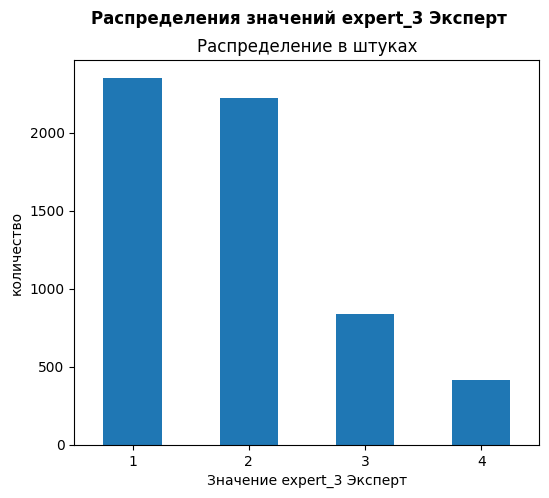

In [24]:
plot_bar(expert_annotations['expert_3'], name='Эксперт')

у разных экспертов разное распределение

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. 
Для решения задачи нужно агрегировать эти оценки.

In [25]:
def expert_score_agg(row):
    experts = [row['expert_1'], row['expert_2'], row['expert_3']]
    mode_scores = pd.Series(experts).mode()
    if len(mode_scores) == 1:
        return mode_scores[0] / 4
    else:
        return 0

In [26]:
expert_annotations['exp_score'] = expert_annotations.apply(expert_score_agg, axis=1)

In [27]:
expert_annotations.query('exp_score == 0').count()

image        126
query_id     126
expert_1     126
expert_2     126
expert_3     126
exp_score    126
dtype: int64

в 126 случаях из 5822 экспертные мнения полностью разошлись, что примерно 2% случаев. Эти строки можем удалить

In [28]:
expert_annotations_agg = expert_annotations.query('exp_score != 0')

в датасетe с краудсорсинговыми оценками:

confirmation_share - Доля исполнителей, подтвердивших, что текст соответствует картинке.
confirms - Количество исполнителей, подтвердивших, что текст соответствует картинке.
disproves - Количество исполнителей, подтвердивших, что текст не соответствует картинке.

Будем использовать confirmation_share

In [29]:
crowd_annotations['crwd_score'] = crowd_annotations['confirmation_share']

Объединяем экспертные и краудсорсинговых оценоки в одну. Оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4 - если есть обе оценки и принимаем ту которая есть, если вторая отсутствует. 
Целевая переменная должна иметь значения от 0 до 1.

In [30]:
head_info(expert_annotations_agg)

Первые 5 строк и информация по датафрейму: 



image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  exp_score  
0         1     0.2500  
1         2     0.2500  
2         2     0.2500  
3         2     0.5000  
4         2     0.2500

<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      5696 non-null   object 
 1   query_id   5696 non-null   object 
 2   expert_1   5696 non-null   int64  
 3   expert_2   5696 non-null   int64  
 4   expert_3   5696 non-null   int64  
 5   exp_score  5696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 311.5+ KB



In [31]:
head_info(crowd_annotations)

Первые 5 строк и информация по датафрейму: 



image                     query_id  confirmation_share  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0000   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0000   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0000   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0000   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0000   

   confirms  disproves  crwd_score  
0         3          0      1.0000  
1         0          3      0.0000  
2         0          3      0.0000  
3         0          3      0.0000  
4         0          3      0.0000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               47830 non-null  object 
 1   query_id            47830 non-null  object 
 2   confirmation_share  47830 non-null  float64
 3   confirms            47830 non-null  int64  
 4   disproves           47830 non-null  int64  
 5   crwd_score          47830 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 2.2+ MB



In [32]:
expert_score = expert_annotations_agg[['image', 'query_id', 'exp_score']]
crowd_score = crowd_annotations[['image', 'query_id', 'crwd_score']]

In [33]:
df_score = pd.merge(
    expert_score,
    crowd_score,
    how='outer',
    on=['image', 'query_id']
)

In [34]:
head_info(df_score)

Первые 5 строк и информация по датафрейму: 



image                     query_id  exp_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        NaN   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        NaN   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        NaN   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        NaN   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        NaN   

   crwd_score  
0      1.0000  
1      0.0000  
2      0.0000  
3      0.0000  
4      0.0000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51268 entries, 0 to 51267
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51268 non-null  object 
 1   query_id    51268 non-null  object 
 2   exp_score   5696 non-null   float64
 3   crwd_score  47830 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.6+ MB



In [35]:
def score_agg(row):
    if not pd.isna(row['exp_score']) and not pd.isna(row['crwd_score']):
        return row['exp_score'] * 0.6 + row['crwd_score'] * 0.4
    elif not pd.isna(row['exp_score']):
        return row['exp_score']
    elif not pd.isna(row['crwd_score']):
        return row['crwd_score']
    else:
        return 0

In [36]:
df_score['score'] = df_score.apply(score_agg, axis=1)

In [37]:
df_score['score'].describe()

count   51_268.0000
mean         0.0940
std          0.2157
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          1.0000
Name: score, dtype: float64

In [38]:
head_info(df_score)

Первые 5 строк и информация по датафрейму: 



image                     query_id  exp_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        NaN   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        NaN   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        NaN   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        NaN   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        NaN   

   crwd_score  score  
0      1.0000 1.0000  
1      0.0000 0.0000  
2      0.0000 0.0000  
3      0.0000 0.0000  
4      0.0000 0.0000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51268 entries, 0 to 51267
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51268 non-null  object 
 1   query_id    51268 non-null  object 
 2   exp_score   5696 non-null   float64
 3   crwd_score  47830 non-null  float64
 4   score       51268 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.0+ MB



## Проверка данных

В некоторых странах, где действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

Поэтому все изображения, которые нарушают такие законы, удалим из обучающей выборки.

In [39]:
nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('averaged_perceptron_tagger_eng')
#nltk.download('punkt_tab')
#nltk.download('wordnet')
#nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxims/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
stopwords = nltk_stopwords.words(['english'])

In [41]:
lemmatizer = WordNetLemmatizer()

In [42]:
excluded_words = (
    'baby', 'infant', 'toddler', 'preschooler', 'child', 'children',
    'kid', 'kids', 'preteen', 'tween', 'teen', 'teenager', 'adolescent',
    'youngster', 'youth', 'minor', 'underage', 'juvenile', 'boy', 'girl',
    'son', 'daughter', 'school'
)

In [43]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = text.lower()
    text = text.split()
    text = ' '.join(text)
    return text

In [44]:
def lemmatize(sentence, lemmatizer=lemmatizer):
    tokens = word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    lemmatized_words = [lemmatizer.lemmatize(
        word, pos='v' if tag.startswith('V') else 'n'
    ) for word, tag in tagged]
    text = ' '.join(lemmatized_words)
    return text

In [45]:
train_data['clean_text'] = train_data['query_text'].apply(clean_text)

In [46]:
tqdm_pandas(tqdm())
train_data['lem_text'] = train_data['clean_text'].progress_apply(lemmatize) 

0it [00:00, ?it/s]

In [47]:
def exclude_row(text, excluded_words):
    for word in excluded_words:
        if word in text:
            return False
    return True

In [48]:
mask = train_data['lem_text'].apply(
    lambda text: exclude_row(text, excluded_words))

In [49]:
mask.head()

0    False
1    False
2    False
3    False
4    False
Name: lem_text, dtype: bool

In [50]:
train_data_clean = train_data[mask]

In [51]:
head_info(train_data_clean)

Первые 5 строк и информация по датафрейму: 



image                     query_id  \
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                         query_text  \
22  A man sleeps under a blanket on a city street .   
23  A man sleeps under a blanket on a city street .   
24  A man sleeps under a blanket on a city street .   
25  A man sleeps under a blanket on a city street .   
26  A man sleeps under a blanket on a city street .   

                                       clean_text  \
22  a man sleeps under a blanket on a city street   
23  a man sleeps under a blanket on a city street   
24  a man sleeps under a blanket on a city street   
25  a man sleeps under a blanket on a city street   
26  a man sleeps under a blanket on a city street   

                                        lem_text  
22  a man sleep under a blanket on a city street  
23  a man sleep under a blanket on a city street  
24  a man sleep under a blanket on a city street  
25  a man sleep under a blanket on a city street  
26  a man sleep under a blanket on a city street

<class 'pandas.core.frame.DataFrame'>
Index: 3957 entries, 22 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       3957 non-null   object
 1   query_id    3957 non-null   object
 2   query_text  3957 non-null   object
 3   clean_text  3957 non-null   object
 4   lem_text    3957 non-null   object
dtypes: object(5)
memory usage: 185.5+ KB



In [52]:
images = train_data_clean['image'].unique()

In [53]:
images.shape

(988,)

## Векторизация изображений

Векторизацию изображений проведет при помощи ResNet50 предобученной на ImageNet V2

In [54]:
# Загрузка модели ResNet-50 без классификатора
weights = models.ResNet50_Weights.IMAGENET1K_V2
img_model = models.resnet50(weights=weights)
img_model = torch.nn.Sequential(*list(img_model.children())[:-1])
img_model.eval();

In [55]:
# Трансформации для изображений
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [56]:
class ImageDataset(Dataset):
    def __init__(self, images, image_folder, transform=None):
        """
        Args:
            images (list or array): одномерный массив с именами файлов
            image_folder (str): папка, где лежат изображения
            transform (callable, optional): трансформации для изображений
        """
        self.images = images  # массив имён файлов
        self.image_folder = image_folder  # путь к папке с изображениями
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        filename = self.images[idx]
        # Формируем полный путь: папка + имя файла
        image_path = os.path.join(self.image_folder, filename)

        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, idx  # возвращаем изображение и индекс в массиве
        except Exception as e:
            print(f"Ошибка загрузки {image_path}: {e}")
            # Возвращаем заглушку при ошибке
            return torch.zeros(3, 224, 224), -1

In [57]:
#Путь к папке с изображениями
image_folder = path + TRAIN_IMAGE_FOLDER

In [58]:
def make_image_embaddings(img_model, preprocess, images, image_folder):
    
    # Проверка устройства
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_model.to(device)
    print(f"Using device: {device}")

    dataset = ImageDataset(images, image_folder, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
    
    all_embeddings = []
    all_indices = []
    
    with torch.no_grad():
        for batch_images, batch_indices in tqdm(dataloader):
            valid_mask = batch_indices != -1
            if valid_mask.any():
                batch_images = batch_images[valid_mask].to(device)
                batch_indices = batch_indices[valid_mask]
    
                embeddings = img_model(batch_images)
                embeddings_np = embeddings.squeeze().cpu().numpy()
    
                all_embeddings.append(embeddings_np)
                all_indices.extend(batch_indices.numpy())
                
    # Создание DataFrame с эмбеддингами
    if all_embeddings:
        all_embeddings = np.vstack(all_embeddings)
        embedding_df = pd.DataFrame(
            all_embeddings,
            index=all_indices,
            columns=[f'img_{i}' for i in range(all_embeddings.shape[1])]
        )
    
        # Объединяем результаты в DataFrame 
        df_images = pd.DataFrame({'image': images})
        df_images = df_images.join(embedding_df, how='left')
        print(f"Обработано {len(df_images)} изображений.")
    else:
        print("Не удалось извлечь эмбеддинги ни для одного изображения.")
    
    return df_images

In [59]:
df_images = make_image_embaddings(img_model, preprocess, images, image_folder)

Using device: cpu


  0%|          | 0/31 [00:00<?, ?it/s]

Обработано 988 изображений.


In [60]:
df_images.head()

image  img_0  img_1  img_2  img_3  img_4  img_5  img_6  \
0  1056338697_4f7d7ce270.jpg 0.6885 0.0145 0.0573 1.9563 0.0862 0.0982 0.0000   
1  3187395715_f2940c2b72.jpg 0.0978 0.0000 0.0852 0.0000 0.2775 0.0118 0.1390   
2   463978865_c87c6ca84c.jpg 0.0179 0.0170 0.0471 0.0244 0.1319 0.0203 0.0187   
3   488590040_35a3e96c89.jpg 0.0788 0.0000 0.0000 0.2640 0.0000 0.0714 0.0000   
4   534875358_6ea30d3091.jpg 0.0785 0.0000 0.0000 0.0529 0.3401 0.0028 0.2217   

   img_7  img_8  ...  img_2038  img_2039  img_2040  img_2041  img_2042  \
0 1.1840 0.0000  ...    0.0000    0.0000    0.0000    0.0236    0.3191   
1 0.9063 1.6693  ...    0.0000    0.0000    0.0000    0.1776    0.0079   
2 2.2041 0.0000  ...    0.0000    0.0025    0.0000    0.0000    0.0000   
3 0.1140 0.0023  ...    0.1104    0.0025    0.0627    0.0000    0.0165   
4 6.8098 0.0803  ...    0.0864    0.0000    0.1781    0.0000    0.0634   

   img_2043  img_2044  img_2045  img_2046  img_2047  
0    0.0296    0.2550    0.1291    0.0614    0.0000  
1    0.0000    0.0000    0.0401    0.0000    0.3807  
2    0.0000    0.1286    0.0000    0.0000    0.0000  
3    0.0011    0.1352    0.1575    0.1364    0.0000  
4    0.2830    2.4458    0.0000    0.0000    0.0000  

[5 rows x 2049 columns]

## Векторизация текстов

Векторизируем описания с помощью предобученного трансформера BERT

In [61]:
df_bert = train_data_clean.copy()
df_bert = df_bert.reset_index(drop=True)

In [62]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = transformers.BertModel.from_pretrained("bert-base-uncased")

In [63]:
def tokenize(texts, tokenizer, train=False, max_len=512, overlap=0):
    """
    Токенизирует тексты, при train=False разбивает длинные последовательности на части.
    
    Параметры:
    - texts: pd.Series строк
    - tokenizer: токенизатор (например, из transformers)
    - train: если False — включаем разбиение длинных текстов
    - max_len: максимальная длина одной части (по умолчанию 512)
    - overlap: количество токенов перекрытия между частями (0 = без перекрытия)
    Возвращает:
    - padded: np.array, дополненные последовательности
    - overshoot_mask: np.array, 
      если train=True: (n_samples,) — 1 если длина > max_len, иначе 0
      если tain=False: (n_samples, 2) — [is_overshoot, n_chunks]
    - attention_mask: np.array, маски внимания
    """
    
    # Очищаем данные
    texts = texts.fillna('').astype(str)

    
    all_chunks = []  # все фрагменты после разбиения
    overshoot_info = []  # информация о разбиении: [is_overshoot, n_chunks]


    for text in texts:
        # Токенизируем
        encoded = tokenizer.encode(text, add_special_tokens=True)
        seq_len = len(encoded)
        
        if train or seq_len <= max_len:
            # Не разбиваем: либо test=False, либо длина <= max_len
            all_chunks.append(encoded)
            is_overshoot = 1 if seq_len > max_len else 0
            overshoot_info.append([is_overshoot, 1])  # 1 фрагмент
        else:
            # Разбиваем на части
            n_chunks = (seq_len + max_len - 1) // max_len  # ceil(seq_len / max_len)
            is_overshoot = 1
            
            for i in range(n_chunks):
                start = i * (max_len - overlap)
                end = start + max_len
                chunk = encoded[start:end]
                all_chunks.append(chunk)
            
            overshoot_info.append([is_overshoot, n_chunks])
    

    # Обрезаем и дополняем до max_len
    tokenized_truncated = [seq[:max_len] for seq in all_chunks]
    padded = np.array([
        seq + [0] * (max_len - len(seq))
        for seq in tokenized_truncated
    ])

    # Маска внимания
    attention_mask = (padded != 0).astype(int)


    # Формируем overshoot_mask
    if not train:
        overshoot_mask = np.array(overshoot_info)  # форма (n_total_chunks, 2)
    else:
        overshoot_mask = np.array([info[0] for info in overshoot_info])  # форма (n_samples,)

    return padded, overshoot_mask, attention_mask

In [64]:
def make_embadings_gpu(padded, attention_mask, batch_size, model=bert_model):
    embeddings = []

    # Определение наличия GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Проверяем, что padded и attention_mask одинаковой длины
    assert len(padded) == len(attention_mask), \
        f"padded ({len(padded)}) и attention_mask ({len(attention_mask)}) разной длины!"

    for i in tqdm(range(padded.shape[0] // batch_size)):
        start = batch_size * i
        end = batch_size * (i + 1)
        
        # Перенос на GPU
        batch = torch.LongTensor(padded[start:end]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[start:end]).to(device)
        
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())  # Возврат на CPU


    # Обработка остатка
    if padded.shape[0] % batch_size != 0:
        start = (padded.shape[0] // batch_size) * batch_size
        batch = torch.LongTensor(padded[start:]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[start:]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())


    return np.concatenate(embeddings)

In [65]:
def make_txt_features(texts, tokenizer, train=False, model=bert_model):
    padded, overshoot_mask, attention_mask = tokenize(
        texts,
        tokenizer,
        train=train)
    
    if train:
        attention_mask = attention_mask[overshoot_mask == 0]
    
    features = make_embadings_gpu(
        padded,
        attention_mask,
        batch_size=BATCH_SIZE,
        model=bert_model)
    
    return features

In [66]:
txt_features = make_txt_features(
    df_bert['query_text'], 
    tokenizer, 
    train=True,
    model=bert_model
)

Using device: cpu


  0%|          | 0/39 [00:00<?, ?it/s]

In [67]:
df_features = pd.DataFrame(
        txt_features,
        #index=all_indices,
        columns=[f'txt_{i}' for i in range(txt_features.shape[1])]
    )

In [68]:
# Объединяем результаты в DataFrame 
df_bert = df_bert.join(df_features, how='left')
print(f"Обработано {len(df_bert)} текстов.")

Обработано 3957 текстов.


In [69]:
df_bert.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
1  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
2   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
3   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
4   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                        query_text  \
0  A man sleeps under a blanket on a city street .   
1  A man sleeps under a blanket on a city street .   
2  A man sleeps under a blanket on a city street .   
3  A man sleeps under a blanket on a city street .   
4  A man sleeps under a blanket on a city street .   

                                      clean_text  \
0  a man sleeps under a blanket on a city street   
1  a man sleeps under a blanket on a city street   
2  a man sleeps under a blanket on a city street   
3  a man sleeps under a blanket on a city street   
4  a man sleeps under a blanket on a city street   

                                       lem_text  txt_0   txt_1   txt_2  txt_3  \
0  a man sleep under a blanket on a city street 0.2259 -0.1478 -0.4104 0.0099   
1  a man sleep under a blanket on a city street 0.2259 -0.1478 -0.4104 0.0099   
2  a man sleep under a blanket on a city street 0.2259 -0.1478 -0.4104 0.0099   
3  a man sleep under a blanket on a city street 0.2259 -0.1478 -0.4104 0.0099   
4  a man sleep under a blanket on a city street 0.2259 -0.1478 -0.4104 0.0099   

   txt_4  ...  txt_758  txt_759  txt_760  txt_761  txt_762  txt_763  txt_764  \
0 0.0245  ...  -0.1131  -0.1129  -0.3092  -0.0570   0.1305   0.9883  -0.0926   
1 0.0245  ...  -0.1131  -0.1129  -0.3092  -0.0570   0.1305   0.9883  -0.0926   
2 0.0245  ...  -0.1131  -0.1129  -0.3092  -0.0570   0.1305   0.9883  -0.0926   
3 0.0245  ...  -0.1131  -0.1129  -0.3092  -0.0570   0.1305   0.9883  -0.0926   
4 0.0245  ...  -0.1131  -0.1129  -0.3092  -0.0570   0.1305   0.9883  -0.0926   

   txt_765  txt_766  txt_767  
0  -0.3192   0.4300   0.2431  
1  -0.3192   0.4300   0.2431  
2  -0.3192   0.4300   0.2431  
3  -0.3192   0.4300   0.2431  
4  -0.3192   0.4300   0.2431  

[5 rows x 773 columns]

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [70]:
df_train = df_bert.merge(df_images, how='left', on='image')

In [71]:
df_train = df_train.merge(df_score, how='inner', on=('image', 'query_id'))

In [72]:
df_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
1  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
2   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
3   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
4   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                        query_text  \
0  A man sleeps under a blanket on a city street .   
1  A man sleeps under a blanket on a city street .   
2  A man sleeps under a blanket on a city street .   
3  A man sleeps under a blanket on a city street .   
4  A man sleeps under a blanket on a city street .   

                                      clean_text  \
0  a man sleeps under a blanket on a city street   
1  a man sleeps under a blanket on a city street   
2  a man sleeps under a blanket on a city street   
3  a man sleeps under a blanket on a city street   
4  a man sleeps under a blanket on a city street   

                                       lem_text  txt_0   txt_1   txt_2  txt_3  \
0  a man sleep under a blanket on a city street 0.2259 -0.1478 -0.4104 0.0099   
1  a man sleep under a blanket on a city street 0.2259 -0.1478 -0.4104 0.0099   
2  a man sleep under a blanket on a city street 0.2259 -0.1478 -0.4104 0.0099   
3  a man sleep under a blanket on a city street 0.2259 -0.1478 -0.4104 0.0099   
4  a man sleep under a blanket on a city street 0.2259 -0.1478 -0.4104 0.0099   

   txt_4  ...  img_2041  img_2042  img_2043  img_2044  img_2045  img_2046  \
0 0.0245  ...    0.0236    0.3191    0.0296    0.2550    0.1291    0.0614   
1 0.0245  ...    0.1776    0.0079    0.0000    0.0000    0.0401    0.0000   
2 0.0245  ...    0.0000    0.0000    0.0000    0.1286    0.0000    0.0000   
3 0.0245  ...    0.0000    0.0165    0.0011    0.1352    0.1575    0.1364   
4 0.0245  ...    0.0000    0.0634    0.2830    2.4458    0.0000    0.0000   

   img_2047  exp_score  crwd_score  score  
0    0.0000     0.2500         NaN 0.2500  
1    0.3807     0.5000         NaN 0.5000  
2    0.0000     0.5000      0.0000 0.3000  
3    0.0000     0.5000         NaN 0.5000  
4    0.0000     0.2500         NaN 0.2500  

[5 rows x 2824 columns]

## Обучение модели предсказания соответствия

### Выделение целевого признака

Будем считать, что если оценка больше или равна 0.5 - фотография соответствует описанию target 1 иначе не соответствует target 0

In [73]:
df_train['target'] = np.where(df_train['score'] >= 0.5, 1, 0)

### Разделение на тестовую и валидационную выборки

Разделили выборку на обучающую и валидационную с учетом групп, то есть так, что бы одна и так же фотография не попала и в обучающую и в валидационную выборки

In [74]:
excess_cols = ['image', 'query_id', 'query_text', 'clean_text', 'lem_text', 
               'exp_score', 'crwd_score', 'target', 'score']

In [75]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=RANDOM_STATE)

In [76]:
X=df_train.drop(columns=excess_cols)
y=df_train['target']
groups=df_train['image']

In [77]:
train_idx, val_idx = next(gss.split(X, y, groups=groups))

In [78]:
X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

### Выбор метрики

При выборе метрики нужно учесть следующие особенности:
- нужна метрика для бинарной классификации
- у нас явный дисбаланс классов, подтверждений гораздо меньше чем отрицаний
- для поиска картинок нужно  найти наиболее точно подходящее под описание. Т.е. для нас важнее Истинно положительные предсказания.
Учитывая эти особенности

Для оценки качества модели выберем метрику PR‑AUC (Area Under the Precision‑Recall Curve)
- специально разработана для дисбаланса классов;
- фокусируется только на положительных примерах (класс «подтверждение»);
- показывает, как Precision меняется с ростом Recall при разных порогах классификации;
- напрямую связана с качеством поиска: высокая PR‑AUC означает, что модель находит релевантные картинки с минимальным числом нерелевантных в топе.

### Базовая модель LogisticRegression

In [79]:
logreg_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight={1: 0.1 , 0: 0.9}
)

In [80]:
logreg_model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.9, 1: 0.1}, max_iter=1000,
                   random_state=1234)

In [81]:
# Получение вероятностей для положительного класса
y_scores = logreg_model.predict_proba(X_val)[:, 1]

# Расчёт Precision и Recall для разных порогов
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Расчёт PR‑AUC
pr_auc = auc(recall, precision)

In [82]:
print('PR‑AUC: ', pr_auc)

PR‑AUC:  0.34502829939075086


### CatBoost

In [83]:
boost_model = CatBoostClassifier(
    random_state=RANDOM_STATE,
    loss_function='Logloss',
    verbose=100,
    depth=5,
    iterations=1000,
    learning_rate=0.1,
    thread_count=-1 
)

In [84]:
boost_model.fit(X_train, y_train);

0:	learn: 0.6615835	total: 129ms	remaining: 2m 8s
100:	learn: 0.3529729	total: 6.06s	remaining: 54s
200:	learn: 0.2201065	total: 12s	remaining: 47.8s
300:	learn: 0.1434272	total: 18.1s	remaining: 42.1s
400:	learn: 0.0993294	total: 24.5s	remaining: 36.6s
500:	learn: 0.0691178	total: 30.8s	remaining: 30.7s
600:	learn: 0.0505991	total: 39.2s	remaining: 26s
700:	learn: 0.0378351	total: 45.5s	remaining: 19.4s
800:	learn: 0.0291133	total: 52.3s	remaining: 13s
900:	learn: 0.0230569	total: 59s	remaining: 6.48s
999:	learn: 0.0186122	total: 1m 5s	remaining: 0us


In [85]:
# Получение вероятностей для положительного класса
y_scores = boost_model.predict_proba(X_val)[:, 1]

# Расчёт Precision и Recall для разных порогов
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Расчёт PR‑AUC
pr_auc = auc(recall, precision)
print('PR‑AUC: ', pr_auc)

PR‑AUC:  0.3996467922997424


### Полносвязная нейронная сеть

In [86]:
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.FloatTensor(y_val.values)

In [87]:
X_train_tensor.shape

torch.Size([3142, 2816])

In [88]:
n_in_neurons = 2816
n_hidden_neurons_1 = 128
n_out_neurons = 1
num_epochs = 5000

In [89]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_out_neurons), 
    nn.Sigmoid()
)

In [90]:
torch.manual_seed(RANDOM_STATE)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss = nn.MSELoss()

metrics = {}
results = {}

for epoch in range(num_epochs):
    net.train() 
    
    optimizer.zero_grad()

    preds = net.forward(X_train_tensor).flatten()

    loss_value = loss(preds, y_train_tensor)

    loss_value.backward()

    optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs:
        net.eval()
        preds = net.forward(X_val_tensor).detach().numpy()
        
        precision, recall, thresholds = precision_recall_curve(y_val, preds)
        
        pr_auc = auc(recall, precision)

        print(f'Epoch {epoch}, loss_value: {loss_value:.6f}, PR‑AUC: {pr_auc:.6f}')
        metrics[round(pr_auc, 4)] = epoch
        results[epoch] = {
            'pred': (np.round(y_scores)).astype(int)
        }
print(f'Лучшее значениен PR‑AUC: {max(metrics)} достигается на Epoch {metrics[max(metrics)]}, ')  

Epoch 0, loss_value: 0.252253, PR‑AUC: 0.254277
Epoch 100, loss_value: 0.158927, PR‑AUC: 0.353139
Epoch 200, loss_value: 0.140341, PR‑AUC: 0.364626
Epoch 300, loss_value: 0.123335, PR‑AUC: 0.374921
Epoch 400, loss_value: 0.106038, PR‑AUC: 0.377832
Epoch 500, loss_value: 0.088824, PR‑AUC: 0.390544
Epoch 600, loss_value: 0.072953, PR‑AUC: 0.394655
Epoch 700, loss_value: 0.059088, PR‑AUC: 0.400894
Epoch 800, loss_value: 0.047584, PR‑AUC: 0.400250
Epoch 900, loss_value: 0.038215, PR‑AUC: 0.403249
Epoch 1000, loss_value: 0.030723, PR‑AUC: 0.404003
Epoch 1100, loss_value: 0.024825, PR‑AUC: 0.404877
Epoch 1200, loss_value: 0.020177, PR‑AUC: 0.405061
Epoch 1300, loss_value: 0.016604, PR‑AUC: 0.404092
Epoch 1400, loss_value: 0.013925, PR‑AUC: 0.404471
Epoch 1500, loss_value: 0.011883, PR‑AUC: 0.404328
Epoch 1600, loss_value: 0.010293, PR‑AUC: 0.404627
Epoch 1700, loss_value: 0.009071, PR‑AUC: 0.403943
Epoch 1800, loss_value: 0.008116, PR‑AUC: 0.403959
Epoch 1900, loss_value: 0.007358, PR‑AUC: 0

Лучшее значение метрики PR‑AUC у модели CatBoost. Ее будем использовать на тесте

## Тестирование модели

Для тестирования модели получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберим случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

### Предобработка тестовых изображений

In [91]:
image_folder_test = path + TEST_IMAGE_FOLDER
images_test = test_queries['image'].unique()

In [92]:
df_images_test = make_image_embaddings(
    img_model,
    preprocess,
    images_test,
    image_folder_test
)

Using device: cpu


  0%|          | 0/4 [00:00<?, ?it/s]

Обработано 100 изображений.


### Предобраотка тестовых запросов

Выбираем 10 случайных запросов

In [93]:
test_queries_smpl = test_queries.sample(n=10, random_state=RANDOM_STATE)

In [94]:
test_queries_smpl

query_id  \
67   2121140070_a09644550b.jpg#2   
416  3722572342_6904d11d52.jpg#1   
350  3459871361_92d1ecda36.jpg#0   
358  3466891862_9afde75568.jpg#3   
112  2448210587_9fe7ea5f42.jpg#2   
329  3421547427_53411b6278.jpg#4   
299  3351418768_596ef7fd6f.jpg#4   
64   2107838729_a527e434bd.jpg#4   
27   1468389504_c724bdcad0.jpg#2   
373  3488087117_2719647989.jpg#3   

                                                                                       query_text  \
67                                                A group of people in a large yard toss a disc .   
416                                         A red high speed racing boat skips across the water .   
350                                        A bicyclist is jumping on ramp covered with graffiti .   
358                                                The small dog returns with his stick proudly .   
112  A white bulldog sitting on a tree stump gives paw to an older woman wearing a black jacket .   
329                    The tennis player in the blue shirt is holding his racquet up in the air .   
299                                  A woman in purple with two children in the mouth of a cave .   
64                                                   Little boy standing on the bank of a river .   
27                         Two little girls in pink outfits play on a yellow and red playground .   
373                                          Little brown and white dog running on the sidewalk .   

                         image  
67   2121140070_a09644550b.jpg  
416  3722572342_6904d11d52.jpg  
350  3459871361_92d1ecda36.jpg  
358  3466891862_9afde75568.jpg  
112  2448210587_9fe7ea5f42.jpg  
329  3421547427_53411b6278.jpg  
299  3351418768_596ef7fd6f.jpg  
64   2107838729_a527e434bd.jpg  
27   1468389504_c724bdcad0.jpg  
373  3488087117_2719647989.jpg

In [95]:
test_queries_smpl['clean_text'] = test_queries_smpl['query_text'].apply(clean_text)
test_queries_smpl['lem_text'] = test_queries_smpl['clean_text'].apply(lemmatize) 

In [96]:
mask = test_queries_smpl['lem_text'].apply(
    lambda text: exclude_row(text, excluded_words))

In [97]:
test_queries_smpl = test_queries_smpl.join(mask.to_frame('legal'))

In [98]:
test_queries_smpl = test_queries_smpl.reset_index(drop=True)

In [99]:
txt_features_test = make_txt_features(
    test_queries_smpl['query_text'], 
    tokenizer, 
    train=False,
    model=bert_model
)

Using device: cpu


0it [00:00, ?it/s]

In [100]:
txt_features_test.shape

(10, 768)

In [101]:
df_test_features = pd.DataFrame(
        txt_features_test,
        columns=[f'txt_{i}' for i in range(txt_features_test.shape[1])]
    )

In [102]:
# Объединяем результаты в DataFrame 
test_queries_smpl = test_queries_smpl.join(df_test_features, how='left')

In [103]:
test_queries_smpl.head()

query_id  \
0  2121140070_a09644550b.jpg#2   
1  3722572342_6904d11d52.jpg#1   
2  3459871361_92d1ecda36.jpg#0   
3  3466891862_9afde75568.jpg#3   
4  2448210587_9fe7ea5f42.jpg#2   

                                                                                     query_text  \
0                                               A group of people in a large yard toss a disc .   
1                                         A red high speed racing boat skips across the water .   
2                                        A bicyclist is jumping on ramp covered with graffiti .   
3                                                The small dog returns with his stick proudly .   
4  A white bulldog sitting on a tree stump gives paw to an older woman wearing a black jacket .   

                       image  \
0  2121140070_a09644550b.jpg   
1  3722572342_6904d11d52.jpg   
2  3459871361_92d1ecda36.jpg   
3  3466891862_9afde75568.jpg   
4  2448210587_9fe7ea5f42.jpg   

                                                                                   clean_text  \
0                                               a group of people in a large yard toss a disc   
1                                         a red high speed racing boat skips across the water   
2                                        a bicyclist is jumping on ramp covered with graffiti   
3                                                the small dog returns with his stick proudly   
4  a white bulldog sitting on a tree stump gives paw to an older woman wearing a black jacket   

                                                                             lem_text  \
0                                       a group of people in a large yard toss a disc   
1                                    a red high speed race boat skip across the water   
2                                     a bicyclist be jump on ramp cover with graffiti   
3                                         the small dog return with his stick proudly   
4  a white bulldog sit on a tree stump give paw to an older woman wear a black jacket   

   legal   txt_0  txt_1   txt_2   txt_3  ...  txt_758  txt_759  txt_760  \
0   True  0.2182 0.5833 -0.3034  0.0756  ...  -0.1214  -0.1513   0.1606   
1   True  0.1871 0.5455 -0.2873  0.1787  ...  -0.3060   0.4119  -0.2083   
2   True -0.0765 0.0680 -0.6878  0.1319  ...  -0.0744   0.2183  -0.1857   
3   True  0.1402 0.3995  0.1141 -0.2117  ...  -0.4610   0.5357   0.2342   
4   True -0.4607 0.1024 -0.9511  0.0255  ...  -0.4568  -0.0615  -0.1438   

   txt_761  txt_762  txt_763  txt_764  txt_765  txt_766  txt_767  
0   0.2159   0.0916   0.7778   0.2434  -0.2108   0.0258   0.2153  
1   0.1303   0.1113   0.6999   0.3430  -0.2192   0.0975   0.1433  
2   0.1992   0.4582   1.0245   0.2693  -0.0940   0.1577  -0.0116  
3  -0.1872   0.0691   0.2486   0.0354  -0.0722   0.2663   0.6210  
4   0.1317   0.2587   0.8597   0.1371  -0.0109   0.3151   0.2133  

[5 rows x 774 columns]

In [104]:
def find_image(model, images, query):
    """
    Поиск наиболее подходящего к описанию изображения
    """
    excess_cols = ['query_id', 'query_text', 'image',
                         'clean_text', 'lem_text', 'legal']
    need_cols = ['query_text', 'image', 'proba' ]
    msg = 'This image is unavailable in your country in compliance with local laws.'
    plug = pd.DataFrame({
        'query_text': [query['query_text']],
        'image': [msg],
        'proba': [0.0]
    })
    if not query['legal'].iloc[0]:
        return plug
    query = query.drop('image', axis=1).reset_index(drop=True)
    images = images.reset_index(drop=True)
    query['key'] = 1
    images['key'] = 1
    query = pd.merge(query, images, on='key').drop('key', axis=1)
    X_test = query.drop(excess_cols, axis=1)
    query['proba'] = boost_model.predict_proba(X_test)[:, 1]
    image = query.sort_values(by='proba', ascending=False).head(1)[need_cols]
    return image

In [105]:
found_images = pd.DataFrame()

In [106]:
for i in range(len(test_queries_smpl)):
    image = find_image(bert_model, df_images_test, test_queries_smpl.iloc[[i]])
    found_images = pd.concat([found_images, image], ignore_index=True)

In [107]:
found_images

query_text  \
0                                                              A group of people in a large yard toss a disc .   
1                                                        A red high speed racing boat skips across the water .   
2                                                       A bicyclist is jumping on ramp covered with graffiti .   
3                                                               The small dog returns with his stick proudly .   
4                 A white bulldog sitting on a tree stump gives paw to an older woman wearing a black jacket .   
5                                   The tennis player in the blue shirt is holding his racquet up in the air .   
6            6    A woman in purple with two children in the mouth of a cave .
Name: query_text, dtype: object   
7                            7    Little boy standing on the bank of a river .
Name: query_text, dtype: object   
8  8    Two little girls in pink outfits play on a yellow and red playground .
Name: query_text, dtype: object   
9                                                         Little brown and white dog running on the sidewalk .   

                                                                      image  \
0                                                 3386953179_84c2d7922f.jpg   
1                                                 3386953179_84c2d7922f.jpg   
2                                                 2505465055_f1e6cf9b76.jpg   
3                                                  957682378_46c3b07bcd.jpg   
4                                                 3154152744_4e93ec8a62.jpg   
5                                                 3514297698_0512623955.jpg   
6  This image is unavailable in your country in compliance with local laws.   
7  This image is unavailable in your country in compliance with local laws.   
8  This image is unavailable in your country in compliance with local laws.   
9                                                 1745110280_0cbff5e273.jpg   

   proba  
0 0.5878  
1 0.7758  
2 0.4156  
3 0.3372  
4 0.2713  
5 0.2067  
6 0.0000  
7 0.0000  
8 0.0000  
9 0.5555

### Выводим текст запросов и изображения

In [108]:
def display_images_with_info(df, image_folder_test, placeholder_text=None):
    if placeholder_text is None:
        placeholder_text = 'This image is unavailable in your country in compliance with local laws.'

    fig, axes = plt.subplots(5, 2, figsize=(12, 30))
    axes = axes.flatten()

    for idx, (_, row) in enumerate(df.iterrows()):
        image_filename = row['image']
        query_text = row['query_text']
        proba = row['proba']

        is_placeholder = placeholder_text in str(image_filename)

        if is_placeholder:
            axes[idx].text(0.5, 0.5,
                         placeholder_text,
                         ha='center', va='center',
                         fontsize=10, color='red',
                         wrap=True)
            axes[idx].set_title(f"Вероятность: {proba:.4f}\n"
                                f"Запрос: {query_text}", fontsize=9)
            axes[idx].axis('on')
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])
        else:
            image_path = os.path.join(image_folder_test, image_filename)
            img = plt.imread(image_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f"Запрос: {query_text}\nФайл:" 
                                f"{image_filename}\n"
                                f"Вероятность:{proba:.4f}\n", fontsize=9)
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

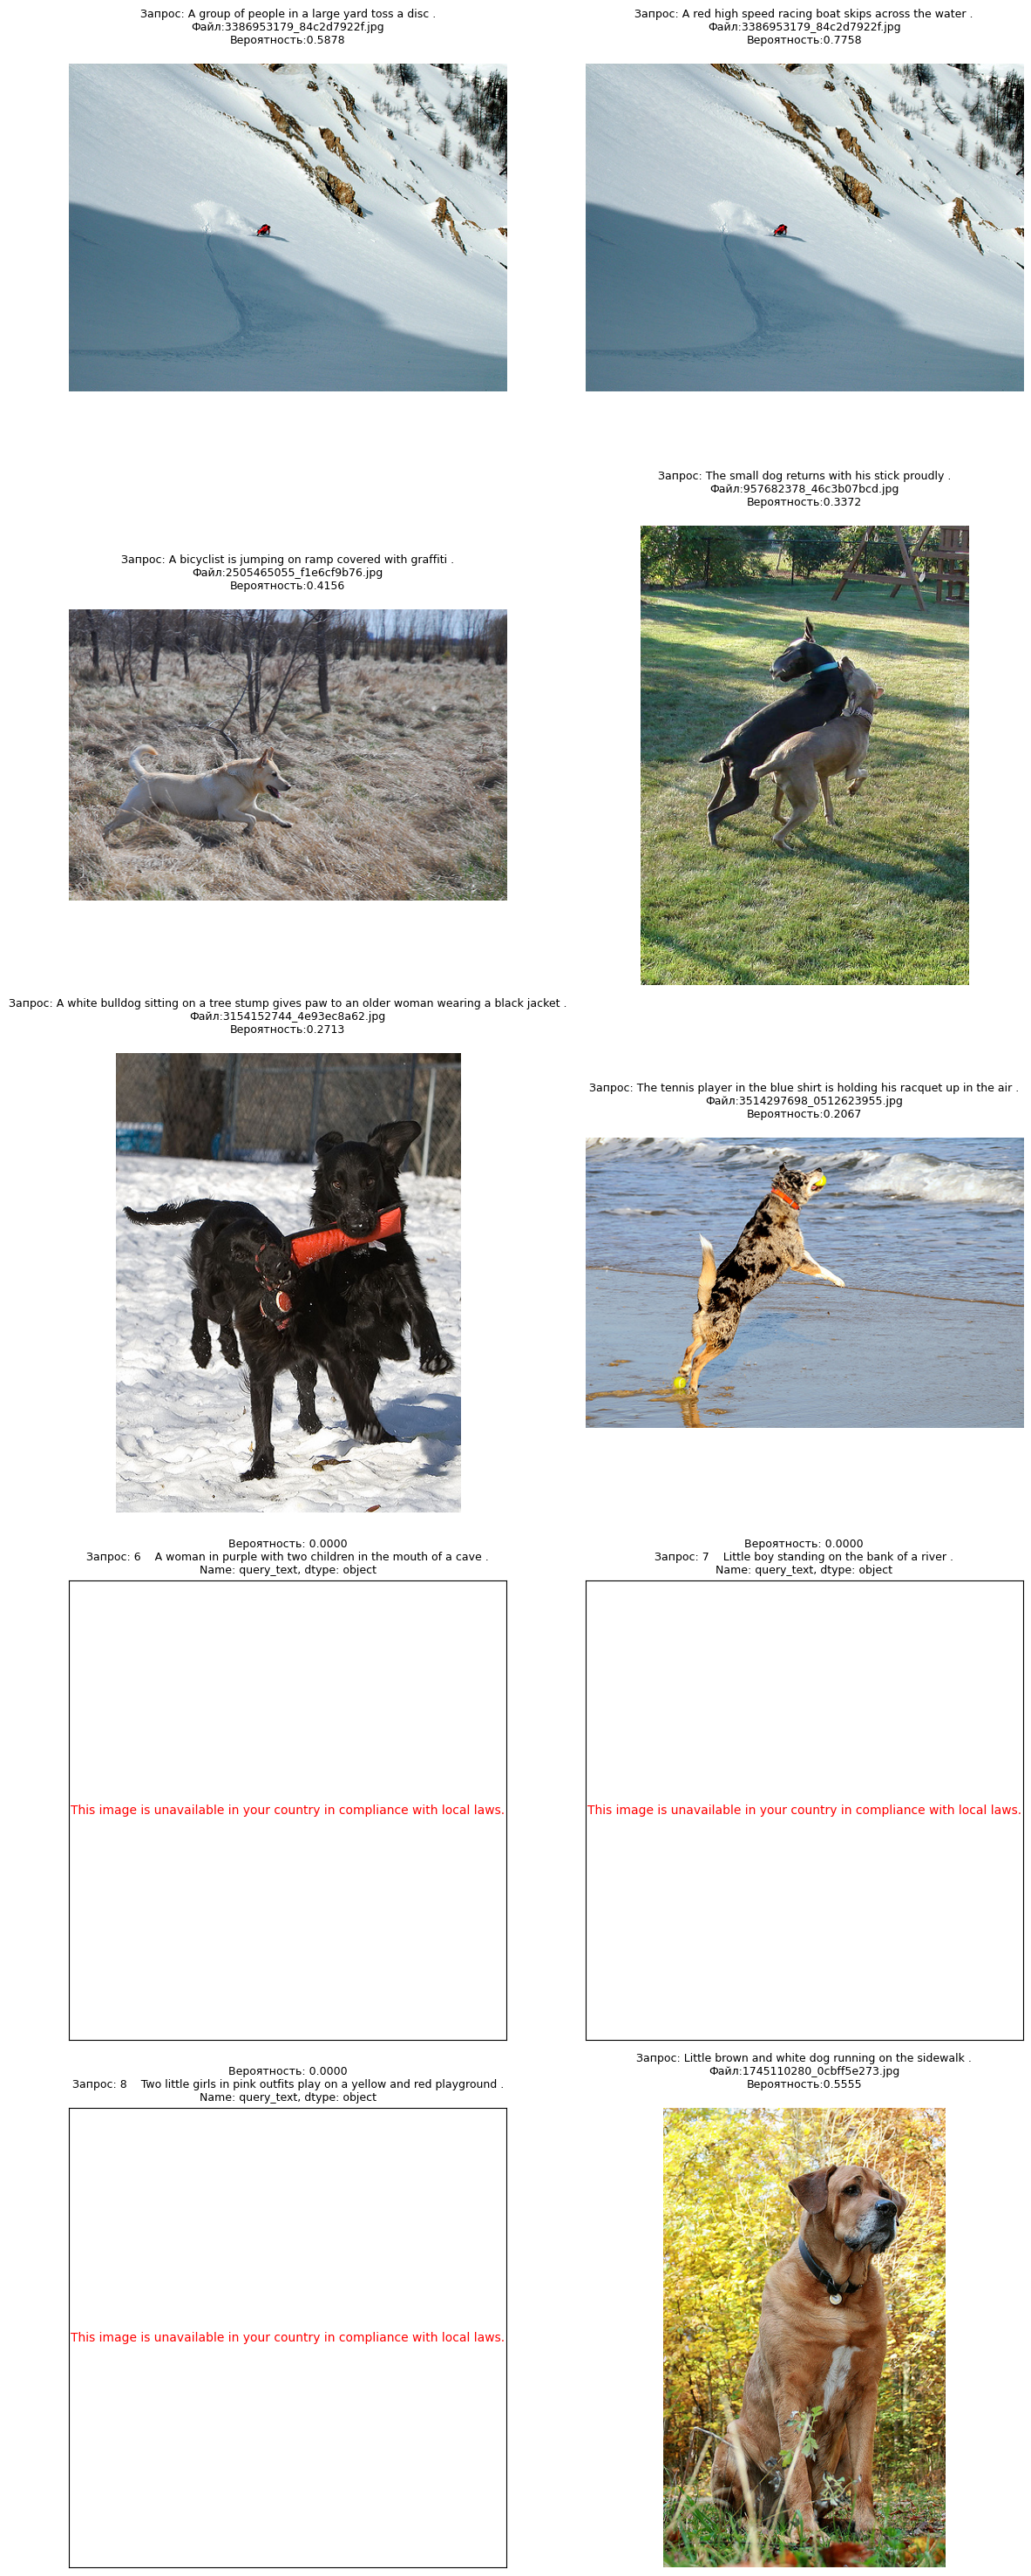

In [109]:
display_images_with_info(found_images, image_folder_test)

Качество поиска изображений оставляет желать лучшего, что отражает и низкое значение метрики. Вероятная причина - значительный дисбаланс данных для обучения. Кроме того, следование требованию об удалении изображений детей - значительно уменьшило объем запросов.

## Выводы

### Подготовка и обзор данных
- Данные соответствуют описанию, но используются разные разделители и в данных с анотациями отсутствуют заголовки.
- Изображения имеют различный размер.


### Исследовательский анализ данных
Датафрейм crowd_annotations
- Стедняя доля подтверждений лишь 7%
- В подтверждениях больше всего 0 т.е. ни один человек не подтвердил
Датафрейм expert_annotations
- Не подтверждения обычьно выдают три человека
- У разных экспертов разное распределение 

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. 
- Для решения задачи  агрегировали  оценки.
- В 126 случаях из 5822 экспертные мнения полностью разошлись, что примерно 2% случаев. Эти строки  удалили

в датасетe с краудсорсинговыми оценками:
- confirmation_share - Доля исполнителей, подтвердивших, что текст соответствует картинке.
- confirms - Количество исполнителей, подтвердивших, что текст соответствует картинке.
- disproves - Количество исполнителей, подтвердивших, что текст не соответствует картинке.
-  использовали confirmation_share
- Оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4 - если есть обе оценки и принимаем ту которая есть, если вторая отсутствует. Целевая переменная должна иметь значения от 0 до 1.

### Проверка данных
Изображения, которые нарушают  законы, удалили из обучающей выборки.


### Векторизация изображений
- Векторизацию изображений провели при помощи ResNet50 предобученной на ImageNet V2

###Векторизация текстов
- Векторизацию описаний провели с помощью предобученного трансформера BERT

### Обучение модели предсказания соответствия
- Исходили из того, что если оценка больше или равна 0.5 - фотография соответствует описанию target 1 иначе не соответствует target 0

#### Разделение на тестовую и валидационную выборки
Разделили выборку на обучающую и валидационную с учетом групп, то есть так, что бы одна и так же фотография не попала и в обучающую и в валидационную выборки

#### Выбор метрики
При выборе метрики  учтены следующие особенности:
- нужна метрика для бинарной классификации
- у нас явный дисбаланс классов, подтверждений гораздо меньше чем отрицаний
- для поиска картинок нужно  найти наиболее точно подходящее под описание. Т.е. для нас важнее Истинно положительные предсказания.
Для оценки качества модели выбрали метрику PR‑AUC (Area Under the Precision‑Recall Curve)

#### Базовая модель LogisticRegression
PR‑AUC:  0.345

#### CatBoost
PR‑AUC:  0.399

#### Полносвязная нейронная сеть
PR‑AUC: 0.374

Лучшее значение метрики PR‑AUC у модели CatBoost. Ее  использовали на тесте

Для тестирования модели получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберим случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

Качество поиска изображений оставляет желать лучшего, что отражает и низкое значение метрики. Вероятная причина - значительный дисбаланс данных для обучения. Кроме того, следование требованию об удалении изображений детей - значительно уменьшило объем запросов.
